# 1. Setup

## 1.1 Connect to data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
! kaggle datasets download -d sarjit07/hand-gesture-recog-dataset
! unzip hand-gesture-recog-dataset.zip -d ./hand-gesture-recog-dataset

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: ./hand-gesture-recog-dataset/data/five/wade94.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade940.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade941.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade942.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade943.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade944.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade945.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade946.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade947.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade948.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade949.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade95.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade950.jpg  
  inflating: ./hand-gesture-recog-dataset/data/five/wade951.jpg  
  inflating

## 1.2 Import

In [7]:
# import librarys
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import cv2
import os
import logging
import pandas as pd
import random
from IPython.display import SVG
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# import necessary tensorflow librarys
from tensorflow.keras import Input
from tensorflow.data import Dataset
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
ZeroPadding2D, RandomRotation, RandomCrop, RandomZoom, BatchNormalization, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# 3. Data Pre-Processing

## 3.1 Load and Split Data

In [8]:
# configuration
VAL_SIZE = 0.2
TEST_SIZE = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_CHANNELS = 1 # NUM_CHANNELS 1 for "grayscale"
DATA_DIR = './hand-gesture-recog-dataset/data'

In [9]:
# load the training data set as gray images
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="training",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# load validation data set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 10321 files belonging to 6 classes.
Using 6193 files for training.
Found 10321 files belonging to 6 classes.
Using 4128 files for validation.


In [10]:
# split validation data set in val_ds and test_ds
val_batches = len(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {BATCH_SIZE} images per Batch
      """)

The dataset is distributed in :
  - 388 Batches for training
  - 129 Batches for testing
  - 129 Batches for validation with each 16 images per Batch
      


## 3.2 Data Exploring

In [11]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['blank', 'fist', 'five', 'ok', 'thumbsdown', 'thumbsup']

In [12]:
# read original data with cv2
total_images = []
total_labels = []
set_of_shapes = set()
set_of_formats = set()
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(root, file)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Load the image here
            if image is not None: # Check if image loaded successfully
                total_images.append(path)
                #Extract the name of class from the root
                total_labels.append(root.split(os.path.sep)[-1])
                set_of_shapes.add(image.shape) # Add shape of the image

# print the maximum and minimum shape object
if set_of_shapes: # Check if set_of_shapes is not empty
    print(f"""Smallest detected shape: {list(sorted(set_of_shapes))[0]}
    Largest detected shape: {list(sorted(set_of_shapes))[-1]}""")
else:
    print("No image shapes were recorded.")

Smallest detected shape: (50, 50)
    Largest detected shape: (215, 240)


In [13]:
# set_of_shapes = set()
# set_of_formats = set()
# for path in total_images:
#   image_temp = cv2.imread(path)
#   image_shape_temp = image_temp.shape
#   if len(set_of_shapes) < 20:
#     set_of_shapes.add(image_shape_temp)
#   if len(set_of_formats) < 100:
#     set_of_formats.add(image_shape_temp[0]/image_shape_temp[1])
#   else:
#     break

# # print the smallest and largest aspect ratio
# print(f"""Smallest aspect ratio: {min(set_of_formats)}
# Largest aspect ratio: {max(set_of_formats)}""")

## 3.3 Data Plotting

In [14]:
# count number of items in each class
def count_images_in_dataset(dataset: Dataset, print_items: bool = False, dataset_description: str = "Training"):
  ds_class_counts = []
  for images, labels in dataset:
    class_counts = tf.reduce_sum(labels, axis=0)
    ds_class_counts.append(class_counts)
  ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
  # Print the number of images in each class for the current dataset optional
  if print_items:
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{dataset_description} - Class '{class_name}': {int(ds_class_counts[i])}")
  return ds_class_counts

In [15]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
 [val_ds, False, "Validation"]]:
 dataset_number_of_occurences[dataset_description] = count_images_in_dataset(dataset, print_items, dataset_description)

In [16]:
# aggregate occurences over the different datasets, to see the class distribution over the whole dataset
all_classes_count = {}
for counter, key in enumerate(CLASS_NAMES):
  all_classes_count[key] = dataset_number_of_occurences['Training'][counter] + dataset_number_of_occurences['Test'][counter] + \
  dataset_number_of_occurences['Validation'][counter]

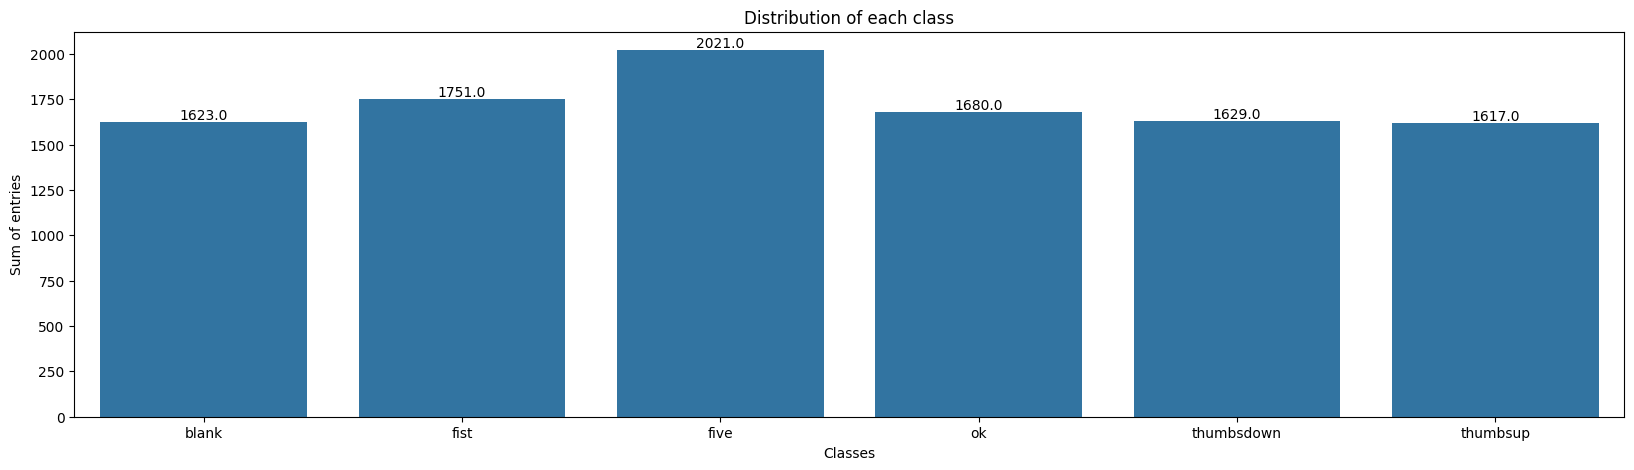

In [17]:
# plot data frequency for the whole dataset
plt.figure(figsize=(20,5))
data = pd.DataFrame(data = {'class_name': all_classes_count.keys(), 'sum of entries': all_classes_count.values()})
data["sum of entries"] = data["sum of entries"].astype("int32")
ax = sns.barplot(data = data, x= "class_name", y="sum of entries")
ax.set(xlabel = "Classes", ylabel = "Sum of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title(f"Distribution of each class")
plt.show()

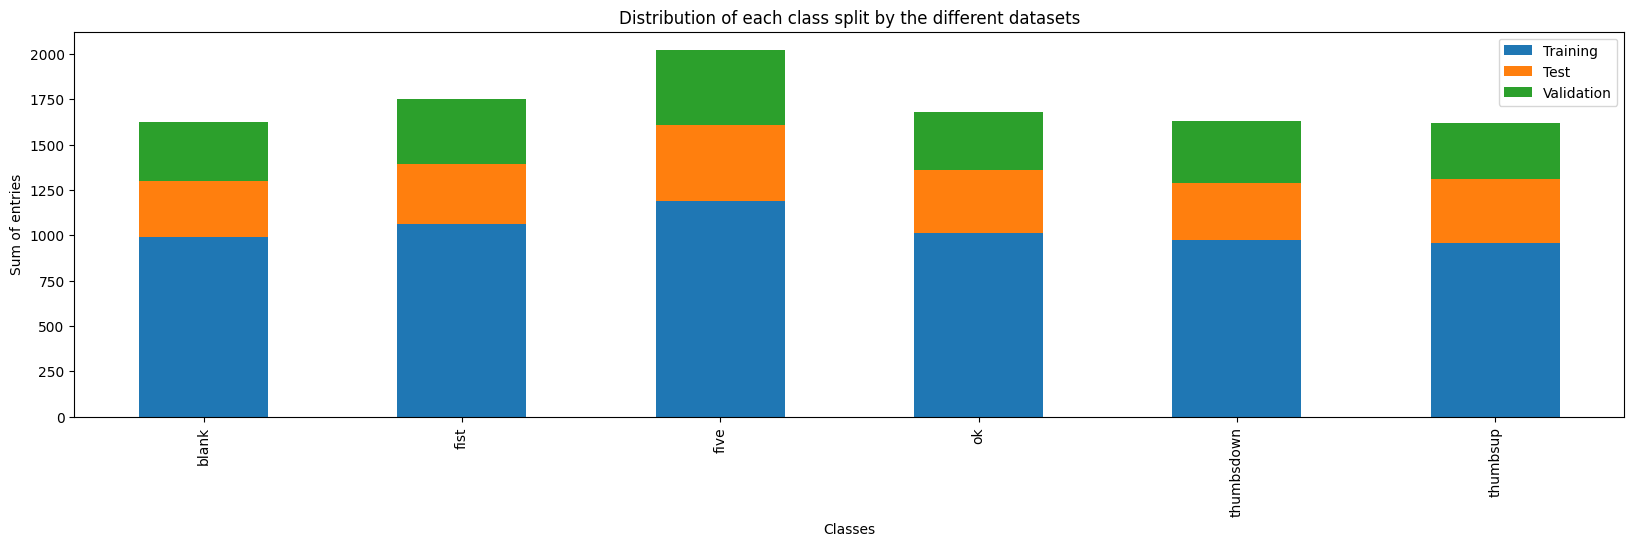

In [18]:
# plot data frequency by set
df_counts_by_classes: pd.DataFrame = pd.DataFrame(dataset_number_of_occurences, index=CLASS_NAMES)
fig, axs = plt.subplots(figsize=(20,5))
axs.set_title(f"Distribution of each class split by the different datasets")
axs.set(xlabel = "Classes", ylabel = "Sum of entries")
df_counts_by_classes.plot(kind='bar', stacked=True, ax=axs)
fig.show()

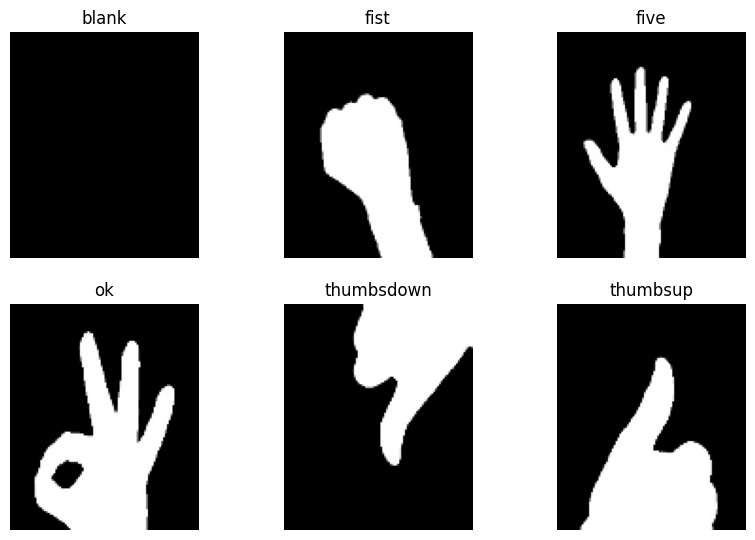

In [19]:
# Visualisation of the distribution in each class
grid_size = (3, 3)
plt.figure(figsize=(10, 10))
for i, subdir in enumerate(CLASS_NAMES[:6]):
    subdir_path = os.path.join(DATA_DIR, subdir)
    files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    if files:
        # The first image in the subdirectory
        first_image_path = os.path.join(subdir_path, files[0])
        image = cv2.imread(first_image_path)

        if image is not None:
            image = cv2.resize(image, (100, 120))
            plt.subplot(grid_size[0], grid_size[1], i + 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f"{subdir}")
            plt.axis('off')
        else:
            print(f"Fehler: Das Bild unter dem Pfad '{first_image_path}' konnte nicht gelesen werden.")
    else:
        print(f"Fehler: Keine Dateien im Verzeichnis '{subdir_path}' gefunden.")
plt.show()

In [20]:
# callback function to update the learning rate every epoch to find the optimal learning rate
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

# define the optimizer
optimizer_lr_finder = tf.keras.optimizers.Adam(learning_rate=1e-8)
# optimizer_training = tf.keras.optimizers.Adam(learning_rate=1e-5)

# Training parameter
EPOCHS = 100
EARLY_STOPPING_PATIENCE = math.sqrt(EPOCHS)
num_classes = len(CLASS_NAMES)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=2,
                                                  restore_best_weights=True)

# 4. Modeltraining

In [21]:
# model
def cnn_model():
  model = Sequential()

  # first conv layer
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.2))

  # second conv layer
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.2))

  # flatten and put a fully connected layer
  model.add(Flatten())
  model.add(Dense(128, activation='relu')) # fully connected
  model.add(Dropout(0.5))

  # softmax layer
  model.add(Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
  return model

model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

In [22]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=2)
score = model.evaluate(test_ds, verbose=0)
print("Accuracy:" + str(score[1]))
print('The error is: %.2f%%' % (100 - score[1] * 100))
model.save('gesture_recognition_cnn.h5')

Epoch 1/100
388/388 - 22s - loss: 3.3939 - accuracy: 0.9031 - val_loss: 0.5445 - val_accuracy: 0.9690 - 22s/epoch - 56ms/step
Epoch 2/100
388/388 - 15s - loss: 0.6096 - accuracy: 0.9685 - val_loss: 0.0394 - val_accuracy: 0.9942 - 15s/epoch - 38ms/step
Epoch 3/100
388/388 - 15s - loss: 0.5296 - accuracy: 0.9698 - val_loss: 0.0141 - val_accuracy: 0.9985 - 15s/epoch - 38ms/step
Epoch 4/100
388/388 - 15s - loss: 0.4781 - accuracy: 0.9790 - val_loss: 0.1911 - val_accuracy: 0.9913 - 15s/epoch - 38ms/step
Epoch 5/100
388/388 - 17s - loss: 0.4510 - accuracy: 0.9776 - val_loss: 0.0431 - val_accuracy: 0.9981 - 17s/epoch - 44ms/step
Epoch 6/100
388/388 - 14s - loss: 0.2918 - accuracy: 0.9837 - val_loss: 0.0115 - val_accuracy: 0.9990 - 14s/epoch - 37ms/step
Epoch 7/100
388/388 - 14s - loss: 0.4920 - accuracy: 0.9816 - val_loss: 0.0041 - val_accuracy: 0.9995 - 14s/epoch - 37ms/step
Epoch 8/100
388/388 - 15s - loss: 0.3958 - accuracy: 0.9868 - val_loss: 0.0356 - val_accuracy: 0.9985 - 15s/epoch - 38

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 5. Evaluation

In [23]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

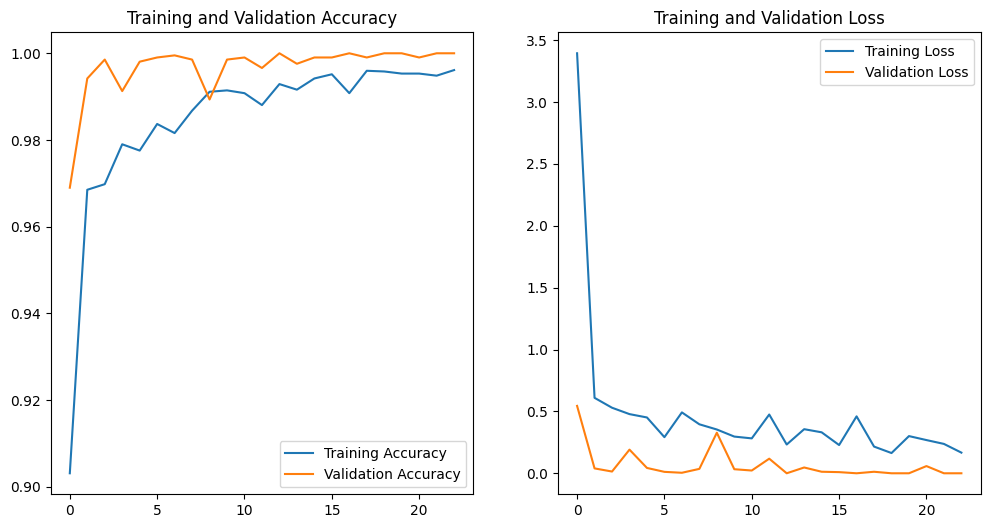

In [24]:
plot_history(history)

In [39]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("Accuracy on Test Data", test_acc)

129/129 - 1s - loss: 0.0113 - accuracy: 0.9995 - 1s/epoch - 10ms/step
Accuracy on Test Data 0.9995155334472656


129/129 [==============================] - 3s 20ms/step - loss: 0.0113 - accuracy: 0.9995
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       312
         1.0       1.00      1.00      1.00       324
         2.0       1.00      1.00      1.00       413
         3.0       1.00      1.00      1.00       340
         4.0       1.00      1.00      1.00       326
         5.0       1.00      1.00      1.00       349

    accuracy                           1.00      2064
   macro avg       1.00      1.00      1.00      2064
weighted avg       1.00      1.00      1.00      2064



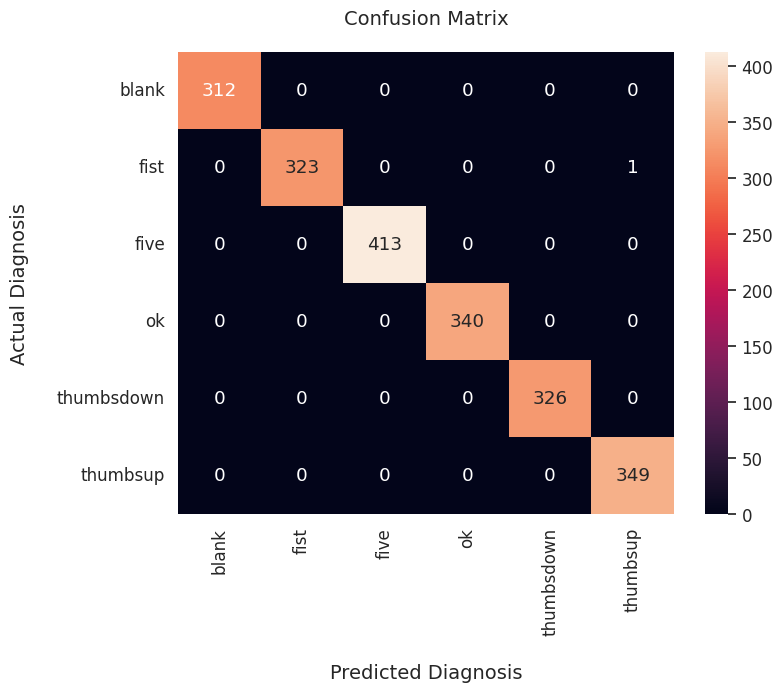

In [40]:
# iterate over the test dataset and store predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

model.evaluate(test_ds)
print(classification_report(labels, predictions))

conf_matrix = confusion_matrix(labels, predictions)
# Display confusion matrix
# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)

# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap
ax = sns.heatmap(conf_matrix, annot=True, fmt='d')

# set x-axis label and ticks.
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(CLASS_NAMES, rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(CLASS_NAMES, rotation=0)

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

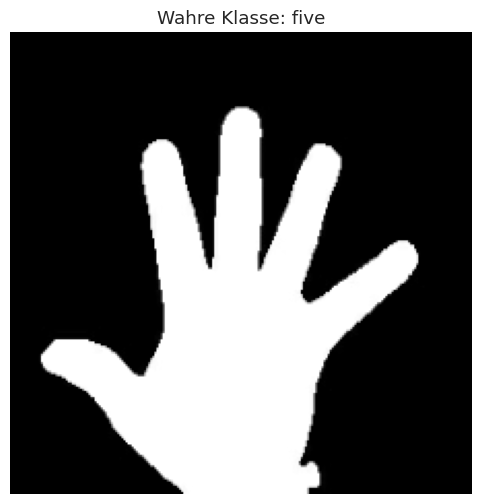

In [27]:
# Anzahl der Bilder im Dataset
dataset_size = sum(1 for _ in test_ds)

shuffled_ds = test_ds.shuffle(buffer_size=dataset_size)

# Iteriere über das Dataset, um ein zufälliges Bild und die zugehörigen Labels zu bekommen
for images, labels in shuffled_ds.take(1):  # Hier nimmst du nur das erste Element (Batch) aus dem durchmischten Dataset
    # Nehme das erste Bild aus dem Batch
    image = images[0:1]  # Hier nimmst du das erste Bild aus dem Batch
    true_labels = labels[0]  # Hier nimmst du die zugehörigen Labels zum ersten Bild

# Konvertiere die true_labels in den Klassenindex oder -label, je nach Bedarf
true_class_index = np.argmax(true_labels)
true_label = CLASS_NAMES[true_class_index]

# Plot des Bildes
plt.figure(figsize=(6, 6))
plt.imshow(np.squeeze(image), cmap='gray')  # Hier wird das Bild geplottet (ohne die Batch-Dimension)
plt.title(f'Wahre Klasse: {true_label}')
plt.axis('off')
plt.show()

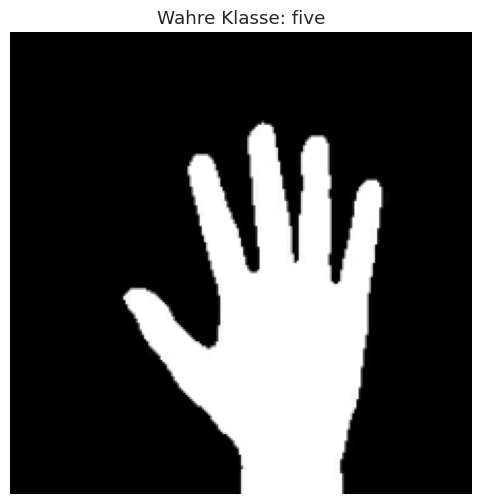

In [28]:
# Iteriere über das Dataset, um das erste Bild und die zugehörigen Labels zu bekommen
for images, labels in test_ds.take(1):  # Hier nimmst du nur das erste Element (Batch) aus dem Dataset
    # Nehme das erste Bild aus dem Batch
    image = images[0:1]  # Hier nimmst du das erste Bild aus dem Batch
    true_labels = labels[0]  # Hier nimmst du die zugehörigen Labels zum ersten Bild

# Konvertiere die true_labels in den Klassenindex oder -label, je nach Bedarf
true_class_index = np.argmax(true_labels)
classes = ['blank', 'fist', 'five', 'ok', 'thumbsdown', 'thumbsup']
true_label = CLASS_NAMES[true_class_index]

# Plot des Bildes
plt.figure(figsize=(6, 6))
plt.imshow(np.squeeze(image), cmap='gray')  # Hier wird das Bild geplottet (ohne den Batch-Dimension)
plt.title(f'Wahre Klasse: {true_label}')
plt.axis('off')
plt.show()

In [29]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.titel("Training and Valiadation Accuracy")
# plt.legend(loc='lower right')

In [30]:
# model = load_model('/content/gesture_recognition_cnn.h5')

# image = cv2.imread("/content/roi_30.png")

# # Preprocess the image to match the model's expected input
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# image = cv2.resize(image, (224, 224))  # Resize to 224x224
# image = np.expand_dims(image, axis=0)  # Add batch dimension
# image = np.expand_dims(image, axis=-1) # Add channel dimension

# # Predict the hand gesture
# prediction = model.predict(image)
# label = classes[np.argmax(prediction)]

# print(f"Prediction for the image: {label}")

In [31]:
# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, BatchNormalization
# from keras.layers import Activation, Dropout
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K
# from keras.optimizers import Adam

# import os
# import glob

# import cv2
# import matplotlib.pyplot as plt

In [32]:
# # Visualisation of the distribution in each class
# grid_size = (3, 3)
# plt.figure(figsize=(10, 10))
# for i, subdir in enumerate(labels[:6]):
#     subdir_path = os.path.join(DATASET_PATH, subdir)
#     files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

#     if files:
#         # The first image in the subdirectory
#         first_image_path = os.path.join(subdir_path, files[0])
#         image = cv2.imread(first_image_path)

#         if image is not None:
#             image = cv2.resize(image, (100, 120))
#             plt.subplot(grid_size[0], grid_size[1], i + 1)
#             plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#             plt.title(f"{subdir}")
#             plt.axis('off')
#         else:
#             print(f"Fehler: Das Bild unter dem Pfad '{first_image_path}' konnte nicht gelesen werden.")
#     else:
#         print(f"Fehler: Keine Dateien im Verzeichnis '{subdir_path}' gefunden.")
# plt.show()

In [33]:
# # model
# model = Sequential()

# # first conv layer
# # input shape = (img_rows, img_cols, 1)
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # second conv layer
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # flatten and put a fully connected layer
# model.add(Flatten())
# model.add(Dense(128, activation='relu')) # fully connected
# model.add(Dropout(0.5))

# # softmax layer
# model.add(Dense(6, activation='softmax'))

# # model summary
# optimiser = Adam()
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.summary()

In [34]:
# # Loading the Dataset
# DATASET_PATH = './hand-gesture-recog-dataset/data'

# dataset_path = os.path.join(DATASET_PATH, '*')
# dataset_path = glob.glob(dataset_path)
# dataset_path

In [35]:
# # List of gestures
# labels = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
# labels

In [36]:
# # Pre-Processing
# def preprocessing(img):
#   image = cv2.imread(img)
#   gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#   gray_image = cv2.resize(gray_image,(100, 120))
#   return gray_image

In [37]:
# loaded_img = []
# image_counts = []
# for path in dataset_path:
#   # Get all image in every ordner
#   gesture_path = os.path.join(path, '*')
#   gest_path = glob.glob(gesture_path)
#   image_counts.append(len(gest_path))
#   for i in range(0, len(gest_path)):
#     preprocessed_img = preprocessing(gest_path[i])
#     loaded_img.append(preprocessed_img)

# print(f"Es gibt insgesamt: {len(loaded_img)} Bilder")

In [38]:
# # Visualisation of the distribution in each class
# plt.figure(figsize=(10, 6))
# plt.bar(labels, image_counts)
# plt.xlabel('Klasse')
# plt.ylabel('Anzahl der Bilder')
# plt.title('Anzahl der Bilder je Klasse')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()